# Analyse de l'ensemble des Dataframe d'un vol

Projet de statistiques descriptives MACS3, dans le cadre du cours de Jérôme Lacaille.

_Version 1.0 [28/11/2023] Kraemer Valentin_

## Analyse de notre problématique d'inclinaison de l'avion en fonction de l'angle du levier - cas multi-vols

Dans un second temps, nous appliquerons ces outils d'analyse dans le cas de notre tentative d'interprétation de l'inclinaison de l'avion par rapport à l'angle du levier.


**Importation des modules pour l'analyse**

In [1]:
%reload_ext autoreload
%autoreload 2

# module
import sys
sys.path.append("../")
from src import *

**Récupération de la donnée**

In [2]:
# chemin vers la donnee 
data_dir = '/home/valentin/Documents/Cours/MACS/MACS3/madane/data/data_extracted/'
filelist = glob.glob(data_dir + '*.h5')

# PARAMETRES DE LA DONNEE 
# Avion
_PLANE = 0
ddf = lire_hdf_dask(filelist[_PLANE], repertoire= data_dir)

## Application de la problématiques à tous les vols du même avion 

Rappelons que l'on dispose des fonctions *angle_analysis* qui permet de raisonner sur tous les dataframe de vols indépendemment. On applique alors cette analyse sur tous les vols :

In [3]:
# nouveau dask dataframe sur les angles
ddf_study= ddf.map_partitions(lambda df : angle_analysis_v3(df))

# regression lineaire sur chaque vols
formula = 'theta_levier~theta_vitesse'
regression_dict = ddf_study.map_partitions(lambda df : regression(df, formula)).compute()

# collecte de la liste des dictionnaires sous la forme d'un dataframe 
df_reg = generate_df_reg(regression_dict)

ValueError: Metadata inference failed in `lambda`.

You have supplied a custom function and Dask is unable to 
determine the type of output that that function returns. 

To resolve this please provide a meta= keyword.
The docstring of the Dask function you ran should have more information.

Original error is below:
------------------------
KeyError('ALT')

Traceback:
---------
  File "/home/valentin/.local/lib/python3.10/site-packages/dask/dataframe/utils.py", line 194, in raise_on_meta_error
    yield
  File "/home/valentin/.local/lib/python3.10/site-packages/dask/dataframe/core.py", line 6886, in _emulate
    return func(*_extract_meta(args, True), **_extract_meta(kwargs, True))
  File "/tmp/ipykernel_14916/1186449056.py", line 2, in <lambda>
    ddf_study= ddf.map_partitions(lambda df : angle_analysis_v3(df))
  File "/home/valentin/Documents/Cours/MACS/MACS3/lacaille/project/stats_descriptive_project/livrable/../src/manipulate_dataframe.py", line 143, in angle_analysis_v3
    id_alt_admitted = df_interm['ALT']>alt_min
  File "/home/valentin/.local/lib/python3.10/site-packages/pandas/core/frame.py", line 3896, in __getitem__
    indexer = self.columns.get_loc(key)
  File "/home/valentin/.local/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 3797, in get_loc
    raise KeyError(key) from err


**Un problème ?** Cela provient très certainement du fait que l'on a pas éliminé les records problématiques... Une dichotomie à la main nous permet d'identifier le records indicé 417 comme problématique. En affichant graphiquement celui-ci, nous comprenons rapidement le problème :

<AxesSubplot:xlabel='record_468'>

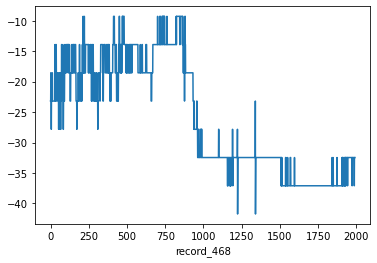

In [4]:
df_anormal = ddf.partitions[417].compute()
df_anormal['ALT [ft]'].plot()

On constate de l'absurdité des valeurs d'altitudes présentes dans ce dataframe.. On souhaite alors réaliser une fonction nous permettant de supprimer les dataframes problématiques du dask.dataframe. 

Pour ce faire, on utilise alors la fonction de Félix *eliminate_records* afin de corriger ce petit problème.

In [5]:
def eliminate_records(df):
    """
    eliminate record function
    @author : Félix Husson 

    Input : 
        dataframe à analyser
    
    Output :
        bol : un boléen qui indique True lorsque le dataframe est problématique (à savoir lorsque l'amplitude des altitudes de l'avion est inférieure à 15k pieds)
    """
    # recuperation du max et du min d'altitude 
    alt_min=df['ALT [ft]'].min()
    alt_max=df['ALT [ft]'].max()
    alt_range=alt_max-alt_min
    bol=False
    
    # verification de l'amplitude d'altitude
    if alt_range<15000:
        bol=True
    return bol
    
# recuperation des indices a garder 
I = ddf.map_partitions(lambda df: eliminate_records(df)).compute()

# recuperation du dask.dataframe sans les records problematiques
ddf2=ddf.partitions[I==False]

Une petite surcouche maison plus tard, on obtient la fonction de séléction des records utilisables :

In [6]:
def select_ddf(ddf):
    """
    select_ddf function 
    @author : Kraemer Valentin 
    Surcouche de la fonction eliminate_records de Félix Husson 

    Input : 
        ddf : dask.dataframe que l'on souhaite traiter pour éliminer les dataframes problématiques 

    Output :
        ddf : dask.dataframe sans les dataframes problématiques 
    """
    I = ddf.map_partitions(lambda df: eliminate_records(df)).compute()
    return ddf.partitions[I==False]

### Nouvel essai 

En utilisant ce prétraitement supplémentaire, nous obtenons alors les résultats suivants 

In [28]:
# selection des records non corrompus
ddf2 = select_ddf(ddf)

# nouveau dask dataframe sur les angles
ddf_study= ddf2.map_partitions(lambda df : angle_analysis(df))
#ddf_study= ddf2.map_partitions(lambda df : angle_analysis_v3(df, alt_min = 10000))   # si vous voulez tester avec les conclusions de analyse dataframe v02

# regression lineaire sur chaque vols
formula = 'theta_vitesse~theta_levier'
regression_dict = ddf_study.map_partitions(lambda df : regression(df, formula)).compute()

# collecte de la liste des dictionnaires sous la forme d'un dataframe 
df_reg = generate_df_reg(regression_dict)

Pas d'erreurs cette fois-ci ! Nous pouvons alors passer aux analyses de sorties 

### Affichage sortie 

#### Significativité de l'analyse en fonction des vols

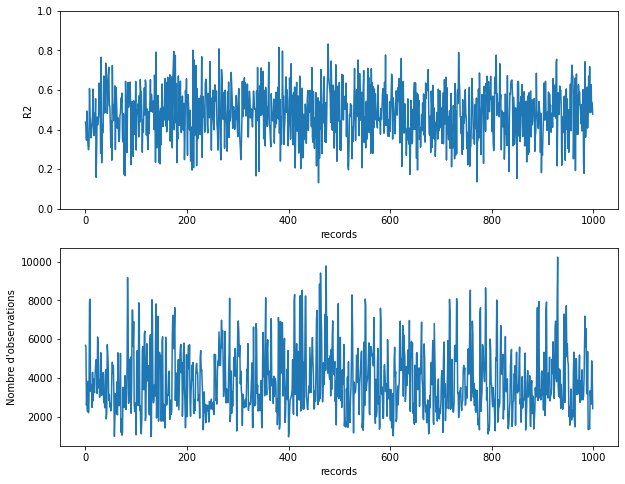

In [29]:
afficher_significativite(df_reg)

In [26]:
def interval_conf(param, df, alpha) :
    """
    interval_conf function 
    realisation rapide d'un intervalle de confiance à partir d'un dataframe

    """
    import scipy.stats as st
    data = df[param]
    Interval = st.norm.interval(alpha=alpha, loc=data.mean(), scale=st.sem(data.values))
    return Interval

In [27]:
print(f"La valeur moyenne de R^2 est de {df_reg['R2'].mean()} pour un intervalle de confiance à 0.95 de {interval_conf('R2', df_reg, alpha = 0.95)}")

La valeur moyenne de R^2 est de 0.461389455800168 pour un intervalle de confiance à 0.95 de (0.4488573257609703, 0.47392158583936567)


Pour le premier vol, nous obtenons un $R^2$ relativement constant au cours des vols avec une valeur moyenne aux alentours de 0.48. Ce n'est pas exceptionnelement satisfaisant lorsque l'on compare celui-ci au R2 de 0.8 du N1 ~ N2 + T1.. Cependant, celui-ci restant constant, nous pouvons penser à un lien intéressant entre l'angle du levier et l'inclinaison de l'avion. Par ailleurs, remarquez que le test de Durbin Waston, significatif de l'autocorrelation entre les deux variables nous démontre un autocorrelation significativement positive :

In [12]:
print(f"La valeur moyenne du test de Durbin Waston est de {df_reg['Durbin_Waston'].mean()} pour un intervalle de confiance à 0.95 de {interval_conf('Durbin_Waston', df_reg, alpha = 0.95)}")

La valeur moyenne du test de Durbin Waston est de 0.38751292991509206 pour un intervalle de confiance à 0.95 de (0.36812740721217785, 0.4068984526180063)


La valeur de $0.41<2.0$ pour le test de Durbin Waston nous indique alors une autocorrelation positive nous rassurant dans nos analyses. Lors du calcul de la vitesse verticale, nous avons été amené à calculer un gradient de<s hauteurs et donc diminuer la taille du jeu de donnée de 1 ! Il est possible que ce décallage infime et que les incertitudes quant à la méthode de calcul des vitesses verticales compte tenu de la nature de l'information sur la hauteur (ne variant pas forcément à chaque pas de temps !) nous donne alors une précision dégradée.

#### Coefficients au cours des vols 

Qu'en est-il de la valeurs des coefficients au cours du temps ?

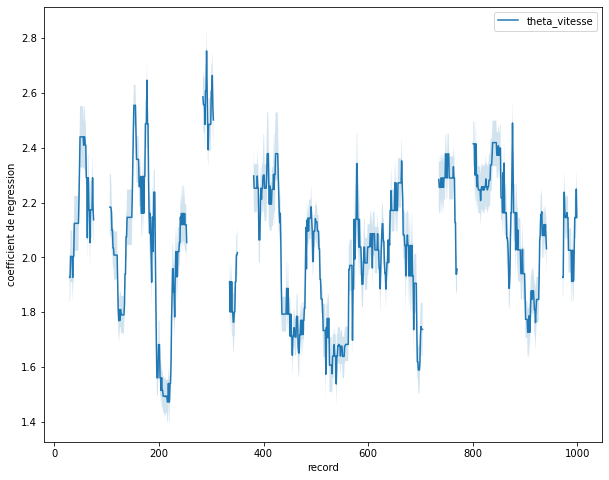

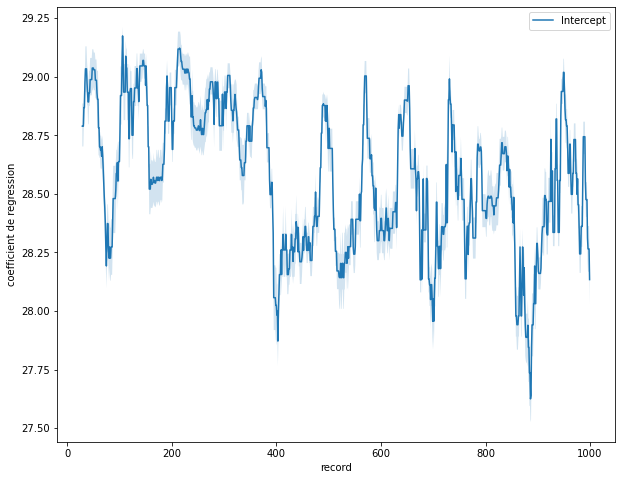

In [13]:
afficher_coeff(df_reg, norm = False, window=30)

Ces graphes sont peut-être plus intéressants ! On applique une médiane glissante de 30 sur les valeurs des coefficients et constate la présence d'un saut plus important dans les alentours du vol 500 ! Par ailleurs, de part est d'autre de vol 'critique', on imagine constater une tendance à la croissance du coefficient de regression devant theta_vitesse dans la relation 

$$
\theta_{levier} = \alpha\theta_{vitesse} + \beta intercept
$$

Le coefficient alpha serait-il en lien avec l'usure de l'apareil, et ce vol 'critique' vers le vol 500 serait-il le dernier vol avant une intervention ? 
Si cela est le cas, il serait intéressant d'expliquer si cette dépendance temporelle provient d'une usure du capteur (on se rappelle du vol 417 problématique!) ou d'un problème physique de l'appareil comme l'assouplissement progressif de la rigidité du levier au fur et à mesure des vols ? 

Toujours est-il que l'on peut considérer en première approximation ces coefficient constants pour une prédiction aux vues des valeurs moyennes (et IC) des coefficients de regression :

In [14]:
print(f"La valeur moyenne du coeff  est de {df_reg['coeff_theta_vitesse'].mean()} pour un intervalle de confiance à 0.95 de {interval_conf('coeff_theta_vitesse', df_reg, alpha = 0.95)}")
print(f"La valeur moyenne du coeff  est de {df_reg['coeff_Intercept'].mean()} pour un intervalle de confiance à 0.95 de {interval_conf('coeff_Intercept', df_reg, alpha = 0.95)}")

La valeur moyenne du coeff  est de 2.1958487597113088 pour un intervalle de confiance à 0.95 de (2.1300756574868402, 2.2616218619357773)
La valeur moyenne du coeff  est de 28.279162569152057 pour un intervalle de confiance à 0.95 de (28.201633776891704, 28.35669136141241)


### Réalisation d'un script condensé pour l'analyse multi-avions

Dans le notebook suivant, nous nous intéresserons à l'analyse sur tous les avions de la flotte d'avion que l'on a à disposition. On réalise alors un petit script condensé de ce que l'on a réalisé précedemment. 

In [15]:
def analyse_flight(file): 
    """
    analyse_flight function
    @author : Kraemer Valentin 

    Input : 
        file : nom du fichier.h5 de données dask d'un avion 
    
    Ouput : 
        affichage graphique du R2, nombre d'observations, des coeeficients de regression 
        df_reg : le dataframe de regression 
    """
    # selection du dask.dataframe non corrompu
    ddf = select_ddf(lire_hdf_dask(file, repertoire= data_dir))

    # nouveau dask dataframe sur les angles
    ddf_study= ddf.map_partitions(lambda df : angle_analysis_v3(df))

    # regression lineaire sur chaque vols
    formula = 'theta_levier~theta_vitesse'
    regression_dict = ddf_study.map_partitions(lambda df : regression(df, formula)).compute()

    # collecte de la liste des dictionnaires sous la forme d'un dataframe 
    df_reg = generate_df_reg(regression_dict)


    # affichage graphique 
    afficher_significativite(df_reg)
    print(f"La valeur moyenne de R^2 est de {df_reg['R2'].mean()} pour un intervalle de confiance à 0.95 de {interval_conf('R2', df_reg, alpha = 0.95)}")
    print(f"La valeur moyenne du test de Durbin Waston est de {df_reg['Durbin_Waston'].mean()} pour un intervalle de confiance à 0.95 de {interval_conf('Durbin_Waston', df_reg, alpha = 0.95)}")

    afficher_coeff(df_reg, norm = False, window=30)
    print(f"La valeur moyenne du coeff  est de {df_reg['coeff_theta_vitesse'].mean()} pour un intervalle de confiance à 0.95 de {interval_conf('coeff_theta_vitesse', df_reg, alpha = 0.95)}")
    print(f"La valeur moyenne du coeff  est de {df_reg['coeff_Intercept'].mean()} pour un intervalle de confiance à 0.95 de {interval_conf('coeff_Intercept', df_reg, alpha = 0.95)}")

    return df_reg
